**Rk**: Due to a lack of patience on our behalf, the iterations of the different algorithms are stopped when $\|\nabla f(x_k)\| \leq \sqrt{N} \times 10^{-2}$

**Rk2**: As computing the gradient and its norm take some time, we don't do it at every iteration but instead check every 50 or 100 iterations the convergence criterion

In [1]:
# !pip install scipy
# !pip install tqdm
# !pip install matplotlib
# !pip install numpy
# !pip install line-profiler
from tqdm import tqdm
import cProfile
import pstats
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix

## I. X-ray tomography

In [2]:
N = 8100
M = 16200
lambda_ = 0.13
delta = 0.02

G = scipy.io.loadmat('data/G.mat')['G']
G = csr_matrix(G)
H = scipy.io.loadmat('data/H.mat')['H']
H = csr_matrix(H)

x_bar = scipy.io.loadmat('data/x.mat')['x'].reshape(N)
w = np.random.randn(M)
y = H @ x_bar + w

x_bar_sinogram = x_bar.reshape((90, 90), order='F')
y_sinogram = y.reshape((90, 180), order='F')

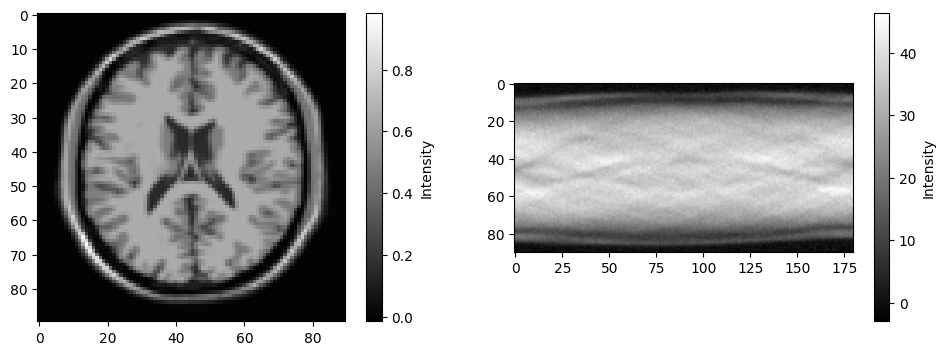

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.colorbar(axs[0].imshow(x_bar_sinogram, cmap='gray'), ax=axs[0], label='Intensity')
fig.colorbar(axs[1].imshow(y_sinogram, cmap='gray'), ax=axs[1], label='Intensity')
plt.show()
plt.close(fig)

## II. Optimization problem

In [4]:
def phi(x: np.ndarray) -> float:
    def phi_scalar(x: float) -> float:
        return np.sqrt(1 + x**2/delta**2)
    phi_vect = np.vectorize(phi_scalar)
    return phi_vect(x)

def phi_prime(x: np.ndarray) -> np.ndarray:
    def phi_prime_scalar(x: float) -> float:
        return x/((delta**2)*phi(x))
    phi_prime_vect = np.vectorize(phi_prime_scalar)
    return phi_prime_vect(x)

def phi_second(x: np.ndarray) -> np.ndarray:
    def phi_second_scalar(x: float) -> float:
        return (phi(x) - x * phi_prime(x))/(delta**2 * phi(x)**2)
    phi_second_vect = np.vectorize(phi_second_scalar)
    return phi_second_vect(x)

def r(x: np.ndarray, G:np.ndarray) -> float:
    return np.sum(phi(G @ x))

def grad_r(x: np.ndarray, G:np.ndarray) -> np.ndarray:
    return G.T @ phi_prime(G @ x)

# def hessian_r(x: np.ndarray, G:np.ndarray) -> np.ndarray:
#     return G.T @ np.diag(phi_second(G @ x).flatten()) @ G        

def f(x: np.ndarray, H: np.ndarray, G:np.ndarray, y:np.array) -> float:
    return 0.5 * np.linalg.norm(H @ x - y)**2 + lambda_ * r(x, G)

def grad_f(x: np.ndarray, H: np.ndarray, G: np.ndarray, y:np.array) -> np.ndarray:
    return H.T @ (H @ x - y) + lambda_ * grad_r(x, G)

# def hessian_f(x: np.ndarray, H: np.ndarray,G:np.ndarray, y:np.array) -> np.ndarray:
#     return H.T @ H + lambda_ * hessian_r(x, G)

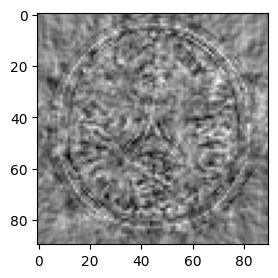

In [5]:
grad_test = grad_f(x_bar, H, G, y)
plt.figure(figsize=(3,3))
plt.imshow(grad_test.reshape((90, 90), order='F'), cmap='gray')
plt.show()
plt.close()

### Q3

## Optimization algorithms

In [6]:
x0 = np.zeros(N)
x0.flags.writeable = False

L = scipy.sparse.linalg.svds(H, k=1, return_singular_vectors=False)[0]**2 + (lambda_/delta**2) * scipy.sparse.linalg.svds(G, k=1, return_singular_vectors=False)[0]**2


### I. Gradient Descent

 20%|██        | 2/10 [00:00<00:01,  6.24it/s]

Iter 0, Loss 415430.3105881212, Grad 75065.03111189071


100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


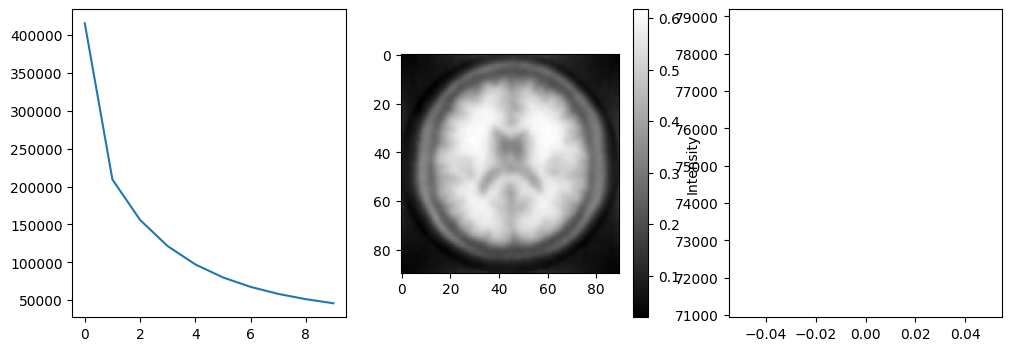

<Figure size 640x480 with 0 Axes>

In [7]:
def grad_desc(x0: np.ndarray, eta: float, lambda_: float, delta: float, max_iter: int):
    x = x0.copy()
    loss_history = []
    grad_norm_history = []
    x_history = []
    for i in tqdm(range(max_iter)):
        x = x - eta*grad_f(x, H, G, y) 
        loss_history.append(f(x, H, G, y))
        x_history.append(x)
        if i%100 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter {i}, Loss {loss_history[-1]}, Grad {grad_norm_history[-1]}')
            if grad_norm_history[-1] < np.sqrt(N)*1e-2:
                print("Gradient descent converged after {} iterations".format(i))
                break
    return x, loss_history, x_history, grad_norm_history

eta = 1/L
max_iter = 10
x_gd, loss_history_gd, x_history_gd, grad_norm_history_gd = grad_desc(x0, eta, lambda_, delta, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_gd)
fig.colorbar(axs[1].imshow(x_gd.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_gd)
plt.show()
plt.savefig('results/grad_desc.png')
plt.close(fig)

### II. MM quadratic algorithm

In [8]:
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator, cg, eigsh, bicg


def A(x: np.ndarray) -> np.ndarray:
    d = np.full(N, L + 1)      # check that 1 is a good margin
    curvature = diags(d).tocsc()

    def matvec(v):
        return curvature @ v
    
    def rmatvec(v):
        return curvature.T @ v
    
    A = LinearOperator((N, N), matvec=matvec, rmatvec=rmatvec)
    return A


def mm_algorithm(x0: np.ndarray, theta: float, max_iter: int): #theta cst over the iterations for now
    x = x0.copy()
    loss_history = []
    x_history = []
    grad_norm_history = []
    for i in tqdm(range(max_iter)):
        grad_mm = grad_f(x, H, G, y)
        A_mm = A(x)
        v, info = bicg(A_mm, grad_mm)
        if info != 0:
            raise ValueError ("CG did not converge")
        
        x = x - theta*v 
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
        if i%50 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter {i}, Loss {loss_history[-1]}, Grad {grad_norm_history[-1]}')
            if grad_norm_history[-1] < np.sqrt(N)*1e-2:
                print("MM algorithm converged after {} iterations".format(i))
                break
    return x, loss_history, x_history, grad_norm_history

 20%|██        | 2/10 [00:00<00:01,  6.54it/s]

Iter 0, Loss 3465593.6764461636, Grad 319906.66401518515


100%|██████████| 10/10 [00:01<00:00,  8.52it/s]


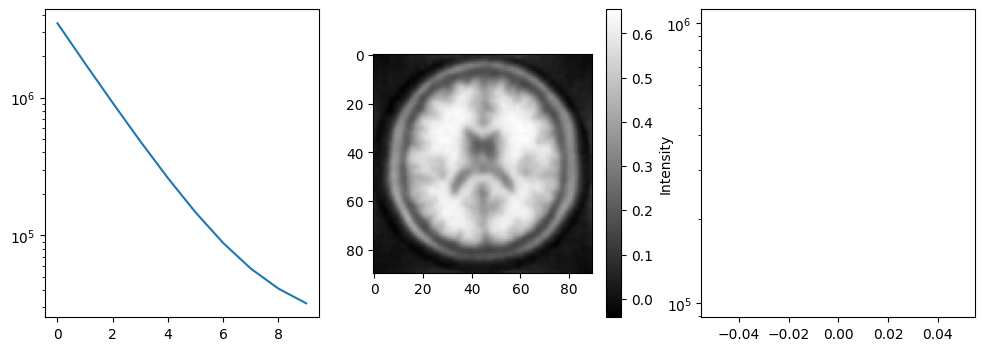

In [9]:
theta = 2
max_iter = 10
x_mm, loss_history_mm, x_history_mm, grad_norm_history_mm = mm_algorithm(x0, theta, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_mm)
axs[0].set_yscale('log')
fig.colorbar(axs[1].imshow(x_mm.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_mm)
axs[2].set_yscale('log')
plt.show()
plt.close(fig)

### III. 3MG algo

In [10]:
def mg_algo(x0: np.ndarray, max_iter: int) -> np.ndarray:
    x = x0.copy()
    loss_history = []
    x_history = []
    grad_norm_history = []
    D = np.zeros((N, 2))
    for i in tqdm(range(max_iter)):
        D[:,0] = -grad_f(x, H, G, y)
        A3mg = A(x)
        u = -np.linalg.pinv(D.T @ A3mg @ D) @ (D.T @ grad_f(x, H, G, y))
        x += D @ u
        D[:,1] = D @ u
        loss_history.append(f(x, H, G, y))
        x_history.append(x)
        if i%20 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter {i}, Loss {loss_history[-1]}, Grad {grad_norm_history[-1]}')
            if grad_norm_history[-1] < np.sqrt(N)*1e-2:
                print("3MG algorithm converged after {} iterations".format(i))
                break
    return x, loss_history, x_history, grad_norm_history

 20%|██        | 2/10 [00:00<00:01,  4.04it/s]

Iter 0, Loss 415523.7231394313, Grad 75083.39462250817


100%|██████████| 10/10 [00:02<00:00,  4.57it/s]


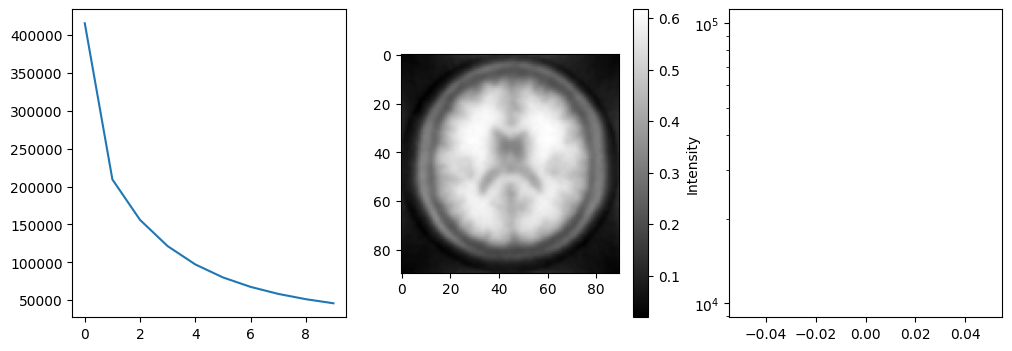

In [11]:
max_iter = 10
x_3mg, loss_history_3mg, x_history_3mg, grad_norm_history_3mg = mg_algo(x0, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_3mg)
fig.colorbar(axs[1].imshow(x_3mg.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_3mg)
axs[2].set_yscale('log')
plt.show()
plt.close(fig)

### IV. Block coordinate MM quadratic algorithm

In [34]:
import time

def Aj(x: np.ndarray, Nj:int) -> np.ndarray:
    d = np.full(Nj, L + 1)      # check that 1 is a good margin
    curvature = diags(d).tocsc()

    def matvec(v):
        return curvature @ v
    
    def rmatvec(v):
        return curvature.T @ v
    
    Aj = LinearOperator((Nj, Nj), matvec=matvec, rmatvec=rmatvec)

    return Aj


def block_mm(x0: np.array, theta: float, max_iter: int, J:int) -> np.array:
    x = x0.copy()
    Nj = N//J
    x_history = []
    loss_history = []
    grad_norm_history = []
    for i in tqdm(range(max_iter)):
        j = i%J
        indices = range(Nj*j, Nj*(j+1))
        xj = x[indices]
        Aj_mm = Aj(x, Nj)
        gradj = grad_f(x, H, G, y)[indices]
        v, info = cg(Aj_mm, gradj)
        if info != 0:
            raise ValueError("Conjugate gradient solver did not converge")

        x[indices] = xj - theta*v       
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
        if i%30 == 0:
            # time.sleep(0.1)
            grad_norm_history.append(np.linalg.norm(gradj))
            print(f'Iter {i}, Loss {loss_history[-1]}, Grad {grad_norm_history[-1]}')
            # if i>4 and loss_history[-1] > loss_history[-2]:
            #     theta /= 2
            if grad_norm_history[-1] < np.sqrt(N)*1e-2:
                break
    return x, loss_history, x_history, grad_norm_history

  1%|          | 3/300 [00:00<00:29,  9.92it/s]

Iter 0, Loss 5061493.612348327, Grad 153072.2619325269


 11%|█         | 33/300 [00:03<00:26, 10.11it/s]

Iter 30, Loss 37938.187825279216, Grad 3133.609512449764


 21%|██        | 63/300 [00:06<00:23, 10.00it/s]

Iter 60, Loss 23029.24673604384, Grad 1488.1079473407588


 31%|███       | 92/300 [00:09<00:21,  9.85it/s]

Iter 90, Loss 18296.2286508901, Grad 971.7945626582823


 41%|████      | 122/300 [00:12<00:19,  9.19it/s]

Iter 120, Loss 16097.12404851086, Grad 690.4960227107412


 51%|█████     | 152/300 [00:15<00:15,  9.72it/s]

Iter 150, Loss 14927.412440171765, Grad 514.4096645941676


 61%|██████    | 182/300 [00:18<00:12,  9.44it/s]

Iter 180, Loss 14254.507290325762, Grad 396.09174843077795


 71%|███████   | 212/300 [00:21<00:08,  9.79it/s]

Iter 210, Loss 13845.53478356875, Grad 312.6235368670493


 81%|████████  | 242/300 [00:24<00:06,  9.61it/s]

Iter 240, Loss 13585.713320197437, Grad 251.65723110351533


 91%|█████████ | 272/300 [00:27<00:02,  9.65it/s]

Iter 270, Loss 13414.716060226883, Grad 206.04346073969256


100%|██████████| 300/300 [00:30<00:00,  9.72it/s]


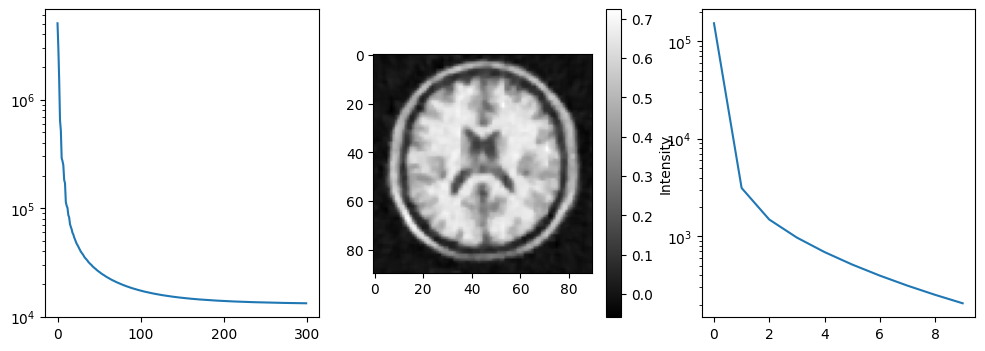

In [43]:
theta = 2
max_iter = 300
J = 5
x_block_mm, loss_history_block_mm, x_history_block_mm, grad_norm_history_block_mm = block_mm(x0, theta, max_iter, J)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_block_mm)
axs[0].set_yscale('log')
fig.colorbar(axs[1].imshow(x_block_mm.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_block_mm)
axs[2].set_yscale('log')
plt.show()
plt.close(fig)

### V. Parallel MM quadratic algorithm

In [14]:
def phi_prime_over_id(x: np.ndarray) -> np.ndarray:
    def phi_prime_over_id_scalar(x: float) -> float:
        return x/((delta**2)*phi(x))
    phi_prime_over_id_vect = np.vectorize(phi_prime_over_id_scalar)
    return phi_prime_over_id_vect(x)

row_sums_H = H @ np.ones(N)
row_sums_G = G @ np.ones(N)
cal_H = H.T @ np.diag(row_sums_H)
cal_H = csr_matrix(cal_H) 
cal_G = G.T @ np.diag(row_sums_G)
cal_G = csr_matrix(cal_G) 

def B(x: np.ndarray) -> np.ndarray:
    b = cal_H @ np.ones(M) + lambda_ * cal_G @ phi_prime_over_id(G @ x)
    b = diags(b).tocsc()

    def matvec(v):
        return b @ v
    
    def rmatvec(v):
        return b.T @ v
    
    B = LinearOperator((N, N), matvec=matvec, rmatvec=rmatvec)
    return B

In [44]:
def parallel_mm_algo(x0, theta: float, max_iter: int):
    x = x0.copy()
    x_history = []
    loss_history = []
    grad_norm_history = []
    n_iter = 0
    for i in tqdm(range(max_iter)):
        B_mm = B(x)
        grad_mm = grad_f(x, H, G, y)
        v, info = cg(B_mm, grad_mm)
        if info != 0:
            raise ValueError("Conjugate gradient solver did not converge")
        x -= theta*v
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
        if i%30 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter: {i}, Grad Norm: {grad_norm_history[-1]}')
    return x, loss_history, x_history, grad_norm_history

  8%|▊         | 2/25 [00:00<00:05,  4.48it/s]

Iter: 0, Grad Norm: 49448.774778185754


 48%|████▊     | 12/25 [00:02<00:02,  4.87it/s]

Iter: 10, Grad Norm: 6771.440591972445


 88%|████████▊ | 22/25 [00:04<00:00,  4.77it/s]

Iter: 20, Grad Norm: 3126.3896720013468


100%|██████████| 25/25 [00:05<00:00,  4.96it/s]


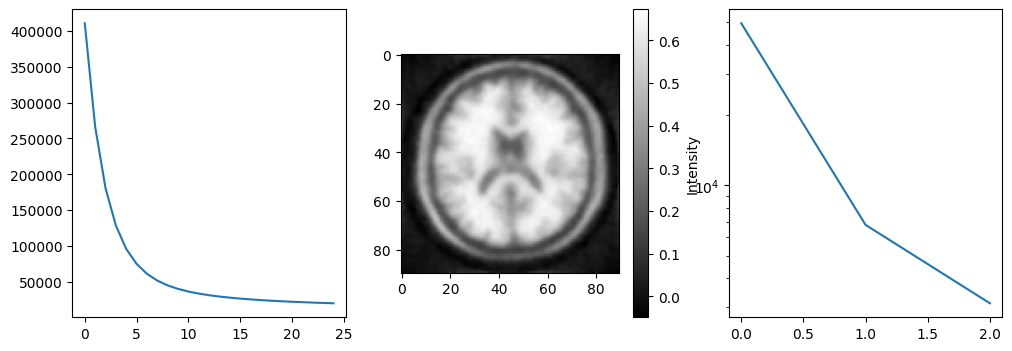

In [45]:
theta = 1
max_iter = 25
x_parallel_mm, loss_history_parallel_mm, x_history_parallel_mm, grad_norm_history_parallel_mm = parallel_mm_algo(x0, theta, max_iter) 

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_parallel_mm)
fig.colorbar(axs[1].imshow(x_parallel_mm.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_parallel_mm)
axs[2].set_yscale('log')
axs[2].yaxis.set_label_position("right")
plt.show()
plt.close(fig)

### VI. Comparison of the methods

In [42]:
def SNR(x: np.ndarray, x_bar: np.ndarray) -> float:
    return 10*np.log10(np.linalg.norm(x_bar)**2/np.linalg.norm(x - x_bar)**2)

print(f'SNR for gradient descent: {SNR(x_gd, x_bar)}')
print(f'SNR for MM algorithm: {SNR(x_mm, x_bar)}')
print(f'SNR for 3MG algorithm: {SNR(x_3mg, x_bar)}')
print(f'SNR for block MM algorithm: {SNR(x_block_mm, x_bar)}')
print(f'SNR for parallel MM algorithm: {SNR(x_parallel_mm, x_bar)}')

SNR for gradient descent: 10.010826625726928
SNR for MM algorithm: 12.075269568575429
SNR for 3MG algorithm: 10.010669847813851
SNR for block MM algorithm: 19.295520811700083
SNR for parallel MM algorithm: 13.330184246432058
